# Automatic differentiation


This example showcase the automatic differentiation capabilities
of the framework.

First, we will import the required packages:


In [1]:
from functools import partial

import numpy as np
import torch

from torch.func import jacrev

import matplotlib.pyplot as plt
import time

We will show how to use automatic differentiation
to automatically compute Cramer Rao Lower Bound.

This can be used as a cost function to optimize acquisition schedules,
for example for quantitative MRI

We'll focuse on a simple Fast Spin Echo acquisition:

In [2]:
# get simulator
from epgtorchx import fse

Cramer Rao Lower Bound is defined as the diagonal of the inverse
of Fisher information matrix. This can be computed as

In [3]:
def calculate_crlb(grad, W=None, weight=1.0):
    if len(grad.shape) == 1:
        grad = grad[None, :]
        
    if W is None:
        W = torch.eye(grad.shape[0], dtype=grad.dtype, device=grad.device)
        
    J = torch.stack((grad.real, grad.imag), axis=0) # (nparams, nechoes)
    J = J.permute(2, 1, 0)
    
    # calculate Fischer information matrix
    In = torch.einsum("bij,bjk->bik", J, J.permute(0, 2, 1))
    I = In.sum(axis=0) # (nparams, nparams)

    # Invert
    return torch.trace(torch.linalg.inv(I) * W).real * weight

notice that we used the trace as a cost function. 
For optimization, we need the gradient of this cost
wrt sequence parameters. 

This can be obtained as:

In [4]:
def _crlb_cost(ESP, T1, T2, phases, flip):
    
    # calculate signal and derivative
    _, grad = fse(flip, phases, ESP, T1, T2, diff=["T2"], asnumpy=False)
    
    # calculate cost
    return calculate_crlb(grad)


def crlb_cost(flip, ESP, T1, T2):    
    flip = torch.as_tensor(flip, dtype=torch.float32)
    flip.requires_grad = True
    
    # phases
    phases = torch.zeros_like(flip)
    
    # get partial function
    _cost = partial(_crlb_cost, ESP, T1, T2, phases)
    _dcost = jacrev(_cost)
    
    return _cost(flip).detach().cpu().numpy(), _dcost(flip).detach().cpu().numpy()

As reference, we compute derivatives via finite differences
approximation. This is inaccurate, but as easy to implement
as automatic differentiation:

In [5]:
def fse_finitediff_grad(flip, phases, ESP, T1, T2, asnumpy=True):    
    sig = fse(flip, phases, ESP, T1, T2, asnumpy=asnumpy)

    # numerical derivative
    dt = 1.0
    dsig = fse(flip, phases, ESP, T1, T2+dt, asnumpy=asnumpy)
    
    return sig, (dsig - sig) / dt

def _crlb_finitediff_cost(ESP, T1, T2, phases, flip):
    
    # calculate signal and derivative
    _, grad = fse_finitediff_grad(flip, phases, ESP, T1, T2, asnumpy=False)
    
    # calculate cost
    return calculate_crlb(grad).cpu().detach().numpy()

def crlb_finitediff_cost(flip, ESP, T1, T2):
    
    # initial cost
    cost0 = _crlb_finitediff_cost(ESP, T1, T2, 0 * flip, flip)
    dcost = []
    
    for n in range(len(flip)):
        # get angles
        angles = flip.copy()
        angles[n] += 1.0
        dcost.append(_crlb_finitediff_cost(ESP, T1, T2, 0 * angles, angles))
                
    return cost0, np.asarray(dcost) - cost0

Now, we can compute optimization for a specific tissue.

We assume T1 = 1000.0 ms and T2 = 100.0 ms:

In [6]:
t1 = 1000.0
t2 = 100.0

Let's compute CRLB for a constant 180.0 refocusing schedule, preceded by
a ramp:

In [7]:
angles = np.concatenate((np.linspace(0, 180.0, 36), np.ones(60, dtype=np.float32) * 180.0))
esp = 5.0 #ms

Let's see the results. Run and plot timings:

[Text(0, 3, '1.76'), Text(0, 3, '5.03')]

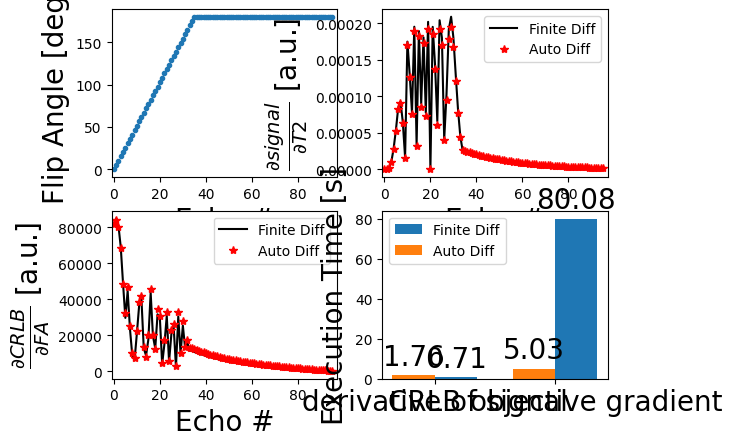

In [8]:
t0 = time.time()
sig0, grad0 = fse_finitediff_grad(angles, 0 * angles, esp, t1, t2)
t1 = time.time()
tgrad0 = t1 - t0

t0 = time.time()
sig, grad = fse(angles, 0 * angles, esp, t1, t2, diff=["T2"])
t1 = time.time()
tgrad = t1 - t0

# cost and derivative
t0 = time.time()
cost0, dcost0 = crlb_finitediff_cost(angles, esp, t1, t2)
t1 = time.time()
tcost0 = t1 - t0

t0 = time.time()
cost, dcost = crlb_cost(angles, esp, t1, t2)
t1 = time.time()
tcost = t1 - t0

fsz = 20
plt.figure()
plt.subplot(2,2,1)
plt.rcParams.update({'font.size': 0.5 * fsz})
plt.plot(angles, '.')
plt.xlabel("Echo #", fontsize=fsz)
plt.xlim([-1, 97])
plt.ylabel("Flip Angle [deg]", fontsize=fsz)

plt.subplot(2,2,2)
plt.rcParams.update({'font.size': 0.5 * fsz})
plt.plot(abs(grad), '-k'), plt.plot(abs(grad0), '*r')
plt.xlabel("Echo #", fontsize=fsz)
plt.xlim([-1, 97])
plt.ylabel(r"$\frac{\partial signal}{\partial T2}$ [a.u.]", fontsize=fsz)
plt.legend(["Finite Diff", "Auto Diff"])


plt.subplot(2,2,3)
plt.rcParams.update({'font.size': 0.5 * fsz})
plt.plot(abs(dcost), '-k'), plt.plot(abs(dcost0), '*r')
plt.xlabel("Echo #", fontsize=fsz)
plt.xlim([-1, 97])
plt.ylabel(r"$\frac{\partial CRLB}{\partial FA}$ [a.u.]", fontsize=fsz)
plt.legend(["Finite Diff", "Auto Diff"])

plt.subplot(2,2,4)

# define labels
# plot results
labels = ['derivative of signal', 'CRLB objective gradient']
time_finite = [round(tgrad0, 2), round(tcost0, 2)]
time_auto = [round(tgrad, 2), round(tcost, 2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
rects1 = plt.bar(x + width/2, time_finite, width, label='Finite Diff')
rects2 = plt.bar(x - width/2, time_auto, width, label='Auto Diff')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Execution Time [s]', fontsize=fsz)
plt.xticks(x, labels, fontsize=fsz)
# plt.ylim([0, 25])
plt.legend()

plt.bar_label(rects1, padding=3, fontsize=fsz)
plt.bar_label(rects2, padding=3, fontsize=fsz)